In [1]:
# Enable code formatting using external plugin: nb_black.
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Linear Regression

### Objective

Implement multivariate **Linear Regression** using _Gradient Descent_ minimization technique.

<a id="#[1]-Setup"></a>
# [1] Setup

### Import and configure required libraries

In [2]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
from prettytable import PrettyTable


# Library versions used in below EDA.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("PrettyTable version:", prettytable.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.5)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.5
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Seaborn version: 0.11.2
PrettyTable version: 3.3.0


<IPython.core.display.Javascript object>

#### Common functions

In [3]:
def get_shape(np_array):
    if not isinstance(np_array, np.ndarray):
        raise ValueError(f"Received {type(np_array)} instead of numpy array.")

    if np_array.size == 0:
        raise ValueError("Received empty numpy array.")

    shape = list(np_array.shape)
    return (shape.pop(), None) if len(shape) == 1 else (shape[0], shape[1])


ENABLE_LOG = False


def text(*args):
    """
    Function to print() input string when logging is enabled.
    """
    if ENABLE_LOG is True:
        print(*args)


def texts(nth=10, table=None):
    """
    Function to print() every `nth` input string when logging is enabled.
    """
    itr_count = 0
    count = 0

    def stack(*args):
        """
        Function to print() input string when logging is enabled.
        """
        nonlocal itr_count, count

        itr_count += 1
        count += 1
        if count == nth and ENABLE_LOG is True:
            if table:
                table.add_row([itr_count, *args])
            else:
                print("Itr:", itr_count, "->", *args)

            count = 0

    return stack


def title(title_str, padding=[1, 1], line_style="="):
    """
    Function to print() input string with some styles, when logging is enabled.
    """
    if ENABLE_LOG is True:
        pad_top, pad_bot = padding
        pt = "\n" * pad_top
        pb = "\n" * pad_bot
        print(pt + title_str + "\n" + line_style * len(title_str) + pb)

<IPython.core.display.Javascript object>

#### Load data-points from the `.csv` file

In [4]:
uv_df = pd.read_csv("./univariate_data_points.csv")
uv_df.head()

,X,Y
0,171,183
1,15,84
2,9,85
3,219,228
4,154,199


<IPython.core.display.Javascript object>

# [2] Data Analysis

In [5]:
rows, cols = uv_df.shape

print("Rows:", rows)
print("Columns:", cols)

Rows: 500
Columns: 2


<IPython.core.display.Javascript object>

In [6]:
uv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X       500 non-null    int64
 1   Y       500 non-null    int64
dtypes: int64(2)
memory usage: 7.9 KB


<IPython.core.display.Javascript object>

In [7]:
uv_df.apply(max)

X    298
Y    272
dtype: int64

<IPython.core.display.Javascript object>

#### Plot attributes

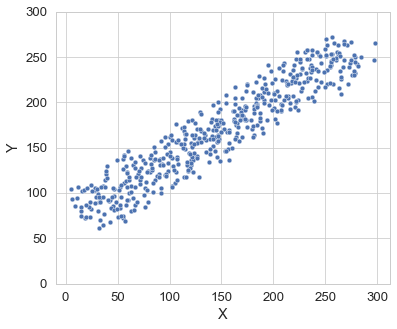

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(6, 5))

sns.scatterplot(data=uv_df, x="X", y="Y")
plt.xticks(ticks=range(0, 350, 50))
plt.yticks(ticks=range(0, 350, 50))

plt.show()

# [3] Implementation

Implement Linear Regression with below features:

1. Feature Scaling.
2. Regularization.
3. Auto adjusting Learning rate (α).

### Hypothesis $h_\theta(x)$

$$
\large
h_\theta(x) = \theta^{T} \cdot x \\[5mm]
\text {Where $\vec{x}$ is a vector of length n}
$$

$$
\large
h_\theta(x) = \theta^{T} \cdot X^{T} \\[5mm]
\text {Where $X$ is a $m \times n$ matrix}
$$

### Model parameters

$$
\large
\theta = \theta_0, \theta_1, \theta_2, \dots, \theta_n
$$

### Cost Function $J(\theta)$

$$
\large
J(\theta) = \frac{1}{2m} \sum_{i = 1}^{m} \frac{1}{2} (h_{\theta}(x^{(i)}) - y^{(i)})^{2} 
$$

### Goal

$$
\large
\min_{\theta} J(\theta)
$$

#### Standardization or Z-score Normalization

In [9]:
def standardization(features):
    """
    Function to implement Standardization or Z-score Normalization.
    """
    # Step 1: Compute mean.
    mean = features.mean(axis=0)

    # Step 2: Compute standard-deviation.
    std = features.std(axis=0)

    def transform(sample=features):
        # Step 3: Remove mean from features.
        z_mean = sample - mean

        # Step 4: Scale features to unit-variance.
        zeros = np.zeros_like(sample, dtype="float")
        return np.divide(z_mean, std, out=zeros, where=std != 0)

    return transform

<IPython.core.display.Javascript object>

#### Plot $J(\theta)$ vs No. of Iterations

In [10]:
def plot_cost_vs_itr(points):
    """
    Function to plot J(θ) vs No. of Iterations to
    check if cost is reducing in each iteration.
    """
    count, _ = get_shape(points)
    text(f"Plotting {count} points:")

    x = points[:, 0]
    y = points[:, 1]

    plt.figure(figsize=(10, 6))

    sns.lineplot(x=x, y=y)
    plt.title("Cost vs Iterations")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost: J(θ)")

    plt.show()

<IPython.core.display.Javascript object>

#### Linear Regression

In [11]:
def linear_regression(X, Y, theta=None, scaling=True):
    """
    Closure to implement multivariate Linear Regression
    using Batch Gradient Descent minimization technique.
    """
    LEARNING_RATE = 1
    MAX_ITR = 1000
    PRECISION = 6
    ITR = 100

    m, n = get_shape(X)
    # m: Total number of records or data-points
    # n: Total number of input-variables or features.

    if not n:
        # Reshape NumPy array to vector.
        text("Reshaping NumPy array, univariate feature, to vector.")
        X = X.reshape((m, 1))

    transform = standardization(X)

    def preprocess(features):
        """
        Function to preprocess input variables:
            1. Feature scaling.
            2. Adding dummy feature theta-zero.
        """
        rows, cols = get_shape(features)

        if scaling:
            # Scaling feature b/w the range -1 std-dev and +1 std-dev.
            features = transform(features)  # Standardized features.

        # Add dummy feature X0 for y-intercept into features
        X_0 = np.ones((rows, 1), features.dtype)
        return np.hstack((X_0, features))  # Concatenate horizontally.

    # Preprocessing features.
    X = preprocess(X)

    # Get final shape after preprocessing.
    m, n = get_shape(X)

    # Initialize empty model parameters if not present.
    if not theta:
        theta = np.zeros(n)

    def fit(alpha=LEARNING_RATE, max_itr=MAX_ITR, nth=ITR, plot_cost=False):
        """
        Fit model parameters(θ) to the dataset i.e., train model using Linear Regression.
        """
        nonlocal theta

        title("Linear Regression")
        text("Model Attributes:")
        text("\tX shape:", get_shape(X))
        text("\tY shape:", get_shape(Y))
        text("\tθ shape:", get_shape(theta))

        # Function to compute hypothesis using matrix multiplication technique.
        # This hypothesis is a Linear Regression model.
        h = lambda X: np.matmul(theta, X.transpose())

        def cost():
            """
            Function to compute cost of the prediction using hypothesis.
            """
            error = h(X) - Y
            return round(np.sum(error**2) / (2 * m), PRECISION)

        def gradient_descent(alpha=LEARNING_RATE):
            """
            Function to compute derivative of Squared Error cost function for
            Gradient Descent algorithm using matrix multiplication technique.
            """
            error = h(X) - Y
            slope = (alpha / m) * np.matmul(X.transpose(), error)

            # Round off and return updated Theta.
            return np.around(theta - slope, PRECISION)

        text("\nModel training started.")
        table = PrettyTable(["Itr", "Cost", "Model parameters"])
        stack = texts(nth, table)

        costs = []
        for itr in range(0, max_itr):
            j_theta = cost()
            theta = gradient_descent(alpha)
            stack(j_theta, theta.tolist())

            # Accumulate iteration count and cost for plotting.
            costs.append([itr, j_theta])

        text(table)
        text("Model training complete!\n")

        if plot_cost:
            plot_cost_vs_itr(np.array(costs))

        def predict(features, precision=PRECISION):
            """
            Function to predict target value for the given features.
            """
            # Preprocessing features before predicting target.
            pp_f = preprocess(np.array(features, ndmin=2))

            # Predict and return target value.
            y = round(h(pp_f).item(), precision)
            return (y, theta.tolist())

        return predict

    return fit

<IPython.core.display.Javascript object>

<a id="#[4]-Training-Model"></a>
# [4] Training Model

#### Initialize Regressor

In [12]:
ENABLE_LOG = True

X = uv_df["X"].values
Y = uv_df["Y"].values

fit = linear_regression(X, Y)

Reshaping NumPy array, univariate feature, to vector.


<IPython.core.display.Javascript object>

Train model using training dataset.

> Note: Set `ENABLE_LOG` to `False` to train model silently (without logs)


Linear Regression

Model Attributes:
	X shape: (500, 2)
	Y shape: (500, None)
	θ shape: (2, None)

Model training started.
+-----+-------------+-------------------------+
| Itr |     Cost    |     Model parameters    |
+-----+-------------+-------------------------+
|  2  | 4031.645758 |  [126.5895, 37.746899]  |
|  4  |  396.285363 | [158.236875, 47.183624] |
|  6  |  169.075339 | [166.148719, 49.542805] |
|  8  |  154.874714 |   [168.12668, 50.1326]  |
|  10 |  153.987176 |  [168.62117, 50.280049] |
|  12 |  153.931705 | [168.744792, 50.316911] |
|  14 |  153.928238 | [168.775698, 50.326127] |
|  16 |  153.928021 | [168.783424, 50.328431] |
|  18 |  153.928008 | [168.785356, 50.329007] |
|  20 |  153.928007 | [168.785839, 50.329151] |
|  22 |  153.928007 |  [168.78596, 50.329187] |
|  24 |  153.928007 |  [168.78599, 50.329196] |
+-----+-------------+-------------------------+
Model training complete!

Plotting 25 points:


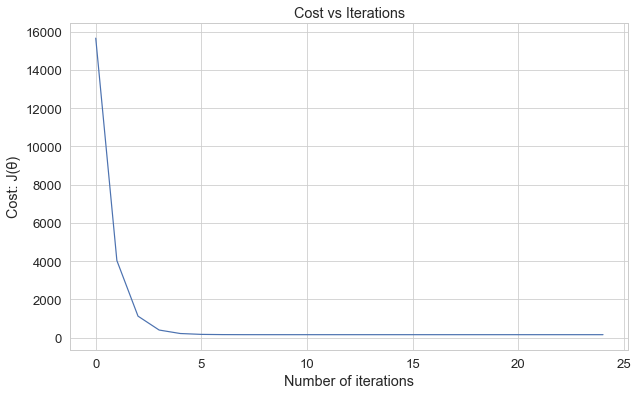

<IPython.core.display.Javascript object>

In [13]:
ENABLE_LOG = True

# Fit Linear Regression model.
predict = fit(alpha=0.5, max_itr=25, nth=2, plot_cost=True)

<a id="#[5]-Testing-Model"></a>
# [5] Testing Model

#### Test 1: Univariate dataset

In [14]:
x = [200]
y, model_prms = predict(x, precision=0)

print("Output:")
print("Input features:", x),
print("Predicted target:", y)
print("Model parameters fit to the dataset:", model_prms)

Output:
Input features: [200]
Predicted target: 205.0
Model parameters fit to the dataset: [168.785995, 50.329197]


<IPython.core.display.Javascript object>

#### Plot Model

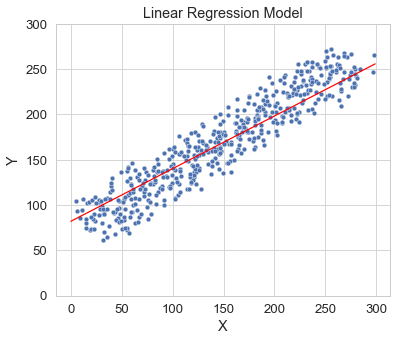

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(6, 5))

t0, t1 = model_prms

x = np.arange(0, 300)
transform = standardization(x)
xt = transform()
y = [t0 + t1 * i for i in xt]

# Model
sns.lineplot(x=x, y=y, color="red")

# Data points
sns.scatterplot(data=uv_df, x="X", y="Y")
plt.title("Linear Regression Model")
plt.xticks(ticks=range(0, 350, 50))
plt.yticks(ticks=range(0, 350, 50))

plt.show()

#### Test 2: Multivariate dataset


Linear Regression

Model Attributes:
	X shape: (5, 4)
	Y shape: (5, None)
	θ shape: (4, None)

Model training started.
+-----+-------------+--------------------------------------------+
| Itr |     Cost    |              Model parameters              |
+-----+-------------+--------------------------------------------+
|  2  | 1824.263822 |   [289.92, 0.963488, 0.688696, 0.257533]   |
|  4  |   3.00338   |  [301.5168, 0.938695, 0.901207, 0.405248]  |
|  6  |   0.067776  | [301.980672, 0.905004, 1.009559, 0.504011] |
|  8  |   0.055586  | [301.999227, 0.884325, 1.071831, 0.564147] |
|  10 |   0.052942  | [301.999969, 0.872041, 1.108485, 0.599954] |
|  12 |   0.052017  | [301.999999, 0.864764, 1.130161, 0.621178] |
|  14 |   0.051693  |   [302.0, 0.860456, 1.142991, 0.633746]    |
|  16 |   0.05158   |   [302.0, 0.857905, 1.150587, 0.641187]    |
|  18 |   0.05154   |   [302.0, 0.856395, 1.155084, 0.645592]    |
|  20 |   0.051526  |   [302.0, 0.855501, 1.157746, 0.648201]    |
|  22 |  

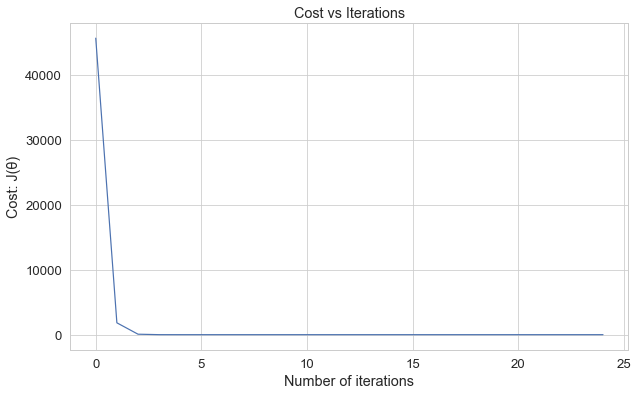

Output:
Input features: [29, 4, 101]
Predicted target: 304.0
Model parameters fit to the dataset: [302.0, 0.854553, 1.160568, 0.650965]


<IPython.core.display.Javascript object>

In [16]:
ENABLE_LOG = True

X = np.array(
    [
        [20, 2, 100],
        [26, 1, 103],
        [25, 0, 109],
        [24, 5, 102],
        [29, 4, 100],
    ]
)
Y = np.array([300, 301, 302, 303, 304])

# Initialize Regressor
fit = linear_regression(X, Y)

# Fit Linear Regression model.
predict = fit(alpha=0.8, max_itr=25, nth=2, plot_cost=True)

# Predict target.
x = [29, 4, 101]
y, model_prms = predict(x, precision=0)

print("Output:")
print("Input features:", x),
print("Predicted target:", y)
print("Model parameters fit to the dataset:", model_prms)